In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio 
from IPython.core.display import display
import pandas as pd

C:\Users\trick\AppData\Local\Temp\ipykernel_17292\3081543886.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


Split the dataset into training and testing sets

In [3]:
labels = {'angry': 0, 'fear': 1, 'happy': 2, 'sad': 3}

In [4]:
X = np.array([])
for folder in os.listdir('./data'):
    for file in os.listdir(f"./data/{folder}"):
        X = np.append(X, f"data/{folder}/{file}")
y = np.array([0]*100 + [1]*100 + [2]*100 + [3]*100)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

Exploratory Data Analysis

In [60]:
max_length = 0
for x in X:
    signal = librosa.load(x)[0]
    if len(signal) > max_length:
        max_length = len(signal)

In [6]:
rand_int = np.random.randint(3,100)
random_samples = X[rand_int::100]
random_samples[2] = X[rand_int+198]

In [7]:
for sample in random_samples:
    display(Audio(sample))

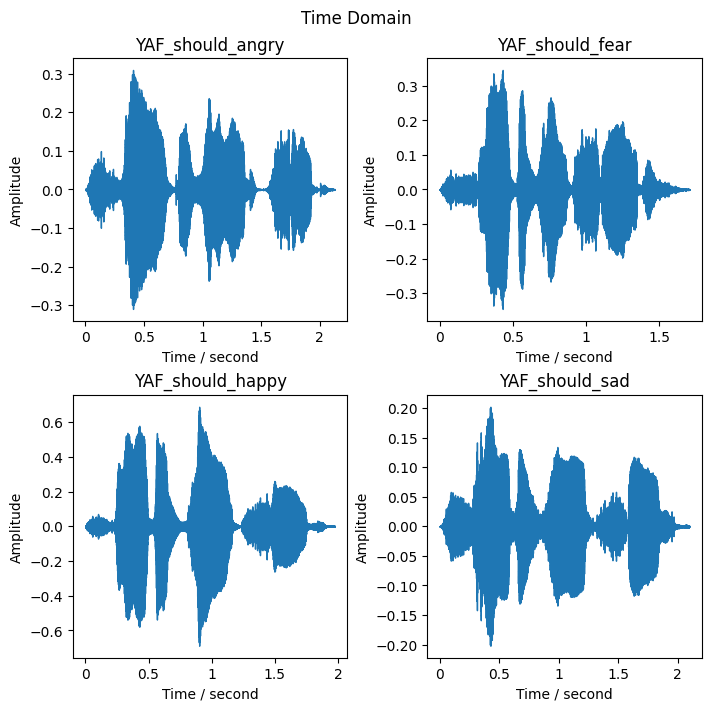

In [8]:
fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(7,7))
fig.suptitle("Time Domain")
for i,sample in enumerate(random_samples):
    signal, sample_rate = librosa.load(sample)
    if (i == 0):
        ax = axs[0,0]
    elif (i == 1):
        ax = axs[0,1]
    elif (i == 2):
        ax = axs[1,0]
    else:
        ax = axs[1,1]
    ax.set_title(sample.split('/')[2].split('.')[0])
    librosa.display.waveshow(y=signal, sr=sample_rate, ax=ax)
    ax.set_xlabel('Time / second')
    ax.set_ylabel('Amplitude')
plt.show()

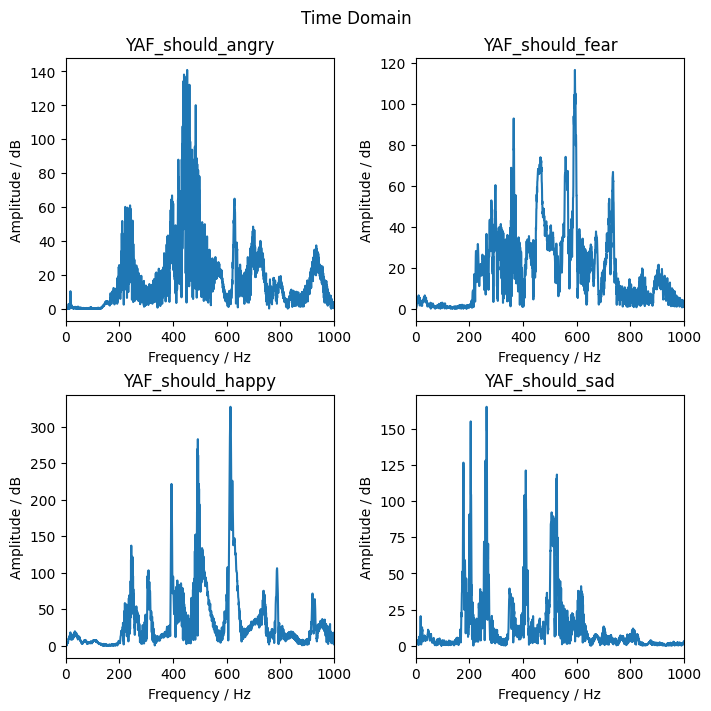

In [9]:
fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(7,7))
fig.suptitle("Time Domain")
for i,sample in enumerate(random_samples):
    signal, sample_rate = librosa.load(sample)
    if (i == 0):
        ax = axs[0,0]
    elif (i == 1):
        ax = axs[0,1]
    elif (i == 2):
        ax = axs[1,0]
    else:
        ax = axs[1,1]
    ax.set_title(sample.split('/')[2].split('.')[0])
    k = np.arange(len(signal))
    T = len(signal)/sample_rate
    freq = k/T

    DATA_0 = np.fft.fft(signal)
    abs_DATA_0 = abs(DATA_0)
    ax.plot(freq, abs_DATA_0)
    ax.set_xlim(0, 1000)
    ax.set_xlabel('Frequency / Hz')
    ax.set_ylabel('Amplitude / dB')
plt.show()

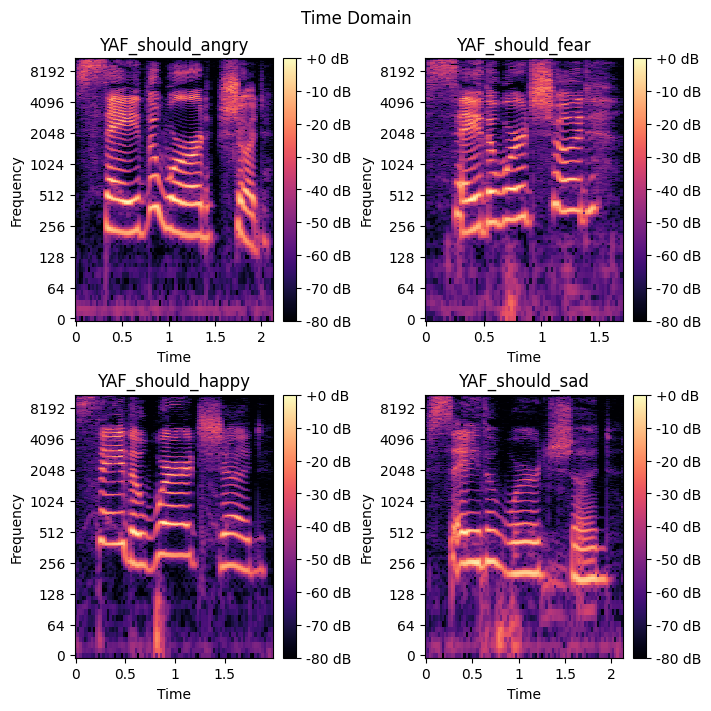

In [10]:
fig, axs = plt.subplots(2,2, constrained_layout=True, figsize=(7,7))
fig.suptitle("Time Domain")
for i,sample in enumerate(random_samples):
    signal, sample_rate = librosa.load(sample)
    if (i == 0):
        ax = axs[0,0]
    elif (i == 1):
        ax = axs[0,1]
    elif (i == 2):
        ax = axs[1,0]
    else:
        ax = axs[1,1]
    ax.set_title(sample.split('/')[2].split('.')[0])

    D = librosa.stft(signal)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    librosa.display.specshow(S_db, x_axis='time', y_axis='log')

    fig.colorbar(librosa.display.specshow(S_db, x_axis='time', y_axis='log', ax=ax), ax=ax, format="%+2.f dB")
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')
plt.show()

Acoustic Feature Extraction

In [53]:
# Time domain feature extraction (Zero-crossing Rate, root-mean-square energy)
def ExtractTimeDomainFeatures(signal):
    time_domain_df = pd.DataFrame()
    S, phase = librosa.magphase(librosa.stft(signal, win_length=25, hop_length=10))
    S.shape
    rms = librosa.feature.rms(S=S)
    time_domain_df['Loudness'] = rms[0]
    zcr = librosa.feature.zero_crossing_rate(y=signal, frame_length=25, hop_length=10)
    zcr_0 = np.pad(zcr[0], (0, len(rms[0]) - len(zcr[0])), 'constant')
    time_domain_df['ZCR'] = zcr_0
    return time_domain_df
    

In [21]:
# Time-frequency domain feature extraction (mfccs, mel-spectogram)
def ExtractTimeFrequencyDomainFeatures(signal, sample_rate):
    time_frequency_domain_df = pd.DataFrame()
    mfccs = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=12, hop_length=10, win_length=25)
    for n_mfcc in range(len(mfccs)):
        time_frequency_domain_df['MFCC_%d'%(n_mfcc+1)] = mfccs[n_mfcc]
    mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=12, win_length=25, hop_length=10)
    for n_mel in range(len(mel_spectrogram)):
        time_frequency_domain_df['Mel_Spectrogram_%d'%(n_mel+1)] = mel_spectrogram[n_mel]
    return time_frequency_domain_df

Feature Post-processing

In [22]:
# Post-processing step 1: Normalize column values to range [-1,1]
def normalize(df):
    for column in df.columns:
        df[column] = ((df[column] - df[column].min()) / (df[column].max() - df[column].min())) * 2 - 1
    return df

# Post-processing step 2: Concatenate features into numpy array
def concat_features(df):
    arr = np.array([])
    for i in range(len(df)):
        arr = np.append(arr, df.iloc[i])
    return arr

# Post-processing step 3: Feature averaging
def average_features(arr, time_window, n_features):
    temp_arr_1 = arr[0:len(arr) - (len(arr) % (time_window * n_features))]
    temp_arr_2 = arr[len(arr) - (len(arr) % (time_window * n_features)):len(arr)]
    avg_arr = np.average(temp_arr_1.reshape(-1, time_window * n_features), axis=1)
    if len(temp_arr_2) > 0:
        avg_arr = np.append(avg_arr, np.average(temp_arr_2.reshape(-1, len(temp_arr_2)), axis=1))
    return avg_arr

Feature extraction and post processing on audio data

In [61]:
X_train_time_domain = []
X_train_time_frequency_domain = []
for i,audio in enumerate(X_train[0:10]):
    temp, sample_rate = librosa.load(audio)
    signal = np.pad(temp, (0, max_length - len(temp)), 'constant')
    time_domain_df = ExtractTimeDomainFeatures(signal)
    time_frequency_domain_df = ExtractTimeFrequencyDomainFeatures(signal, sample_rate)

    time_domain_df = normalize(time_domain_df)
    time_domain_feature_arr = concat_features(time_domain_df)
    time_domain_feature_arr = average_features(time_domain_feature_arr, 10, 2)

    time_frequency_domain_df = normalize(time_frequency_domain_df)
    time_frequency_domain_feature_arr = concat_features(time_frequency_domain_df)
    time_frequency_domain_feature_arr = average_features(time_frequency_domain_feature_arr, 10, 24)
    
    X_train_time_domain.append(time_domain_feature_arr)
    X_train_time_frequency_domain.append(time_frequency_domain_feature_arr)

In [62]:
X_train_time_domain = np.array(X_train_time_domain)

In [64]:
X_train_time_domain.shape

(10, 564)